In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Set plot style
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Load the dataset
try:
    df = pd.read_csv('datasets/data_for_predictions.csv')
    # The first column is the ID, which was the index. We can set it as the index again.
    if "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "id"})
        df = df.set_index('id')
    print("Dataset loaded successfully.")
    display(df.head())
except FileNotFoundError:
    print("ERROR: 'data_for_predictions.csv' not found. Please ensure the file is in the correct directory.")

Dataset loaded successfully.


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
id,,,,,,,,,,,,,,,,,,,,,
"(0, 24011ae4ebbe3035111d65fa7c15bc57)",0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,...,2,6,0,0,1,0,0,0,0,1
"(1, d29c2c54acc38ff3c0614d0a653813dd)",3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,...,76,4,1,0,0,0,0,1,0,0
"(2, 764c75f661154dac3a6c254cd082ea7d)",2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,...,68,8,0,0,1,0,0,1,0,0
"(3, bba03439a292a1e166f80264c16191cb)",3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,...,69,9,0,0,0,1,0,1,0,0
"(4, 149d57cf92fc41cf94415803a877cb4b)",3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,0,...,71,9,1,0,0,0,0,1,0,0


In [3]:
# Separate target variable (y) from features (X)
y = df['churn']
X = df.drop(columns=['churn'])

print("Feature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\nTraining Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Feature Matrix Shape: (14606, 61)
Target Vector Shape: (14606,)

Training Set Shape: (10954, 61)
Testing Set Shape: (3652, 61)


In [4]:
# Initialize the Random Forest classifier
# We use class_weight='balanced' to help the model handle the imbalanced dataset.
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5]
}

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2)

# Train the model
print("Starting hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print("\nBest parameters found:")
print(grid_search.best_params_)

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


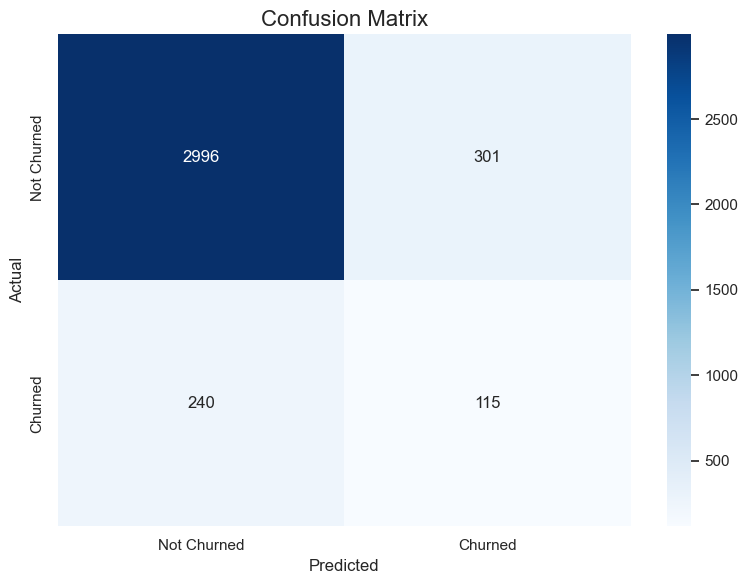

In [ ]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# Compute and display the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'], 
            yticklabels=['Not Churned', 'Churned'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', fontsize=16)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3297
           1       0.28      0.32      0.30       355

    accuracy                           0.85      3652
   macro avg       0.60      0.62      0.61      3652
weighted avg       0.86      0.85      0.86      3652

AUC-ROC Score: 0.6934


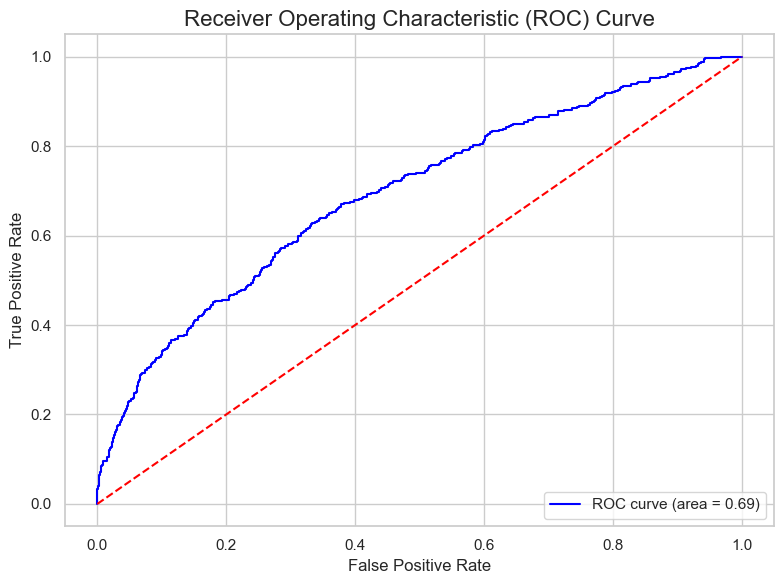

In [10]:
# Display the classification report
print("--- Classification Report ---")
print(metrics.classification_report(y_test, y_pred))

# Calculate and display the AUC-ROC score
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

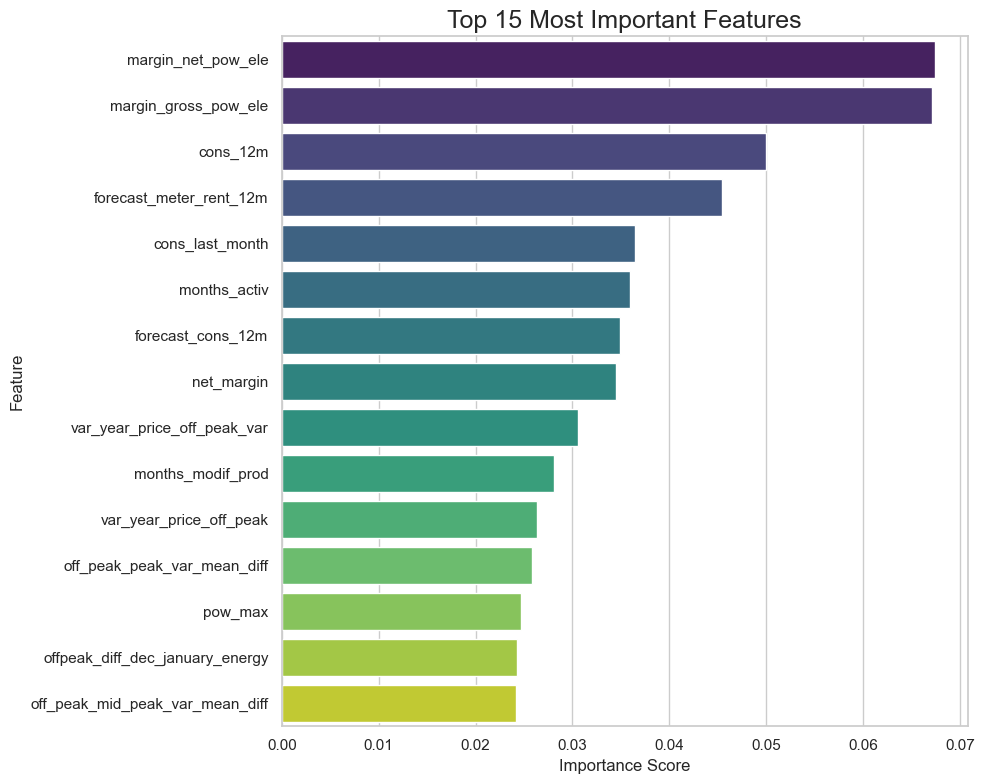

In [11]:
# Extract feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15)

# Plot the most important features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=18)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.tight_layout()
plt.show()